**Ноутбук запускался на Python 3.7.6:**
+ pandas 0.25.3
+ numpy 1.18.1
+ scipy 1.3.2
+ statsmodels 0.10.1

# Динамика средней заработной платы в РФ с 1993 по 2019 год

Данные по динамике заработной платы в РФ с января 1993 по октябрь 2019, необходимо проанализировать ряд и построить прогноз на 24 месяца.

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

#%matplotlib inline


# Изобретать велосипед нет необходимости, функция взята из лекционного ноутбука
def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


### 1. Визуальный анализ ряда

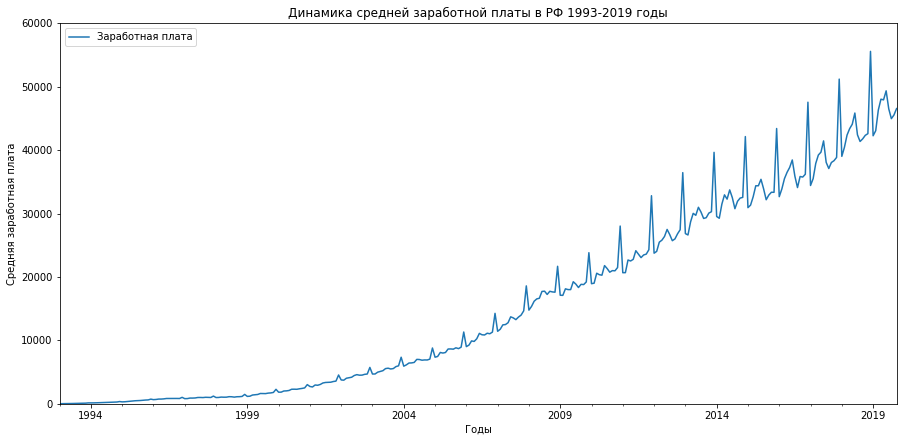

In [2]:
# Загрузим данные
WAG = pd.read_csv('WAG_C_M.csv',';', index_col=['month'], parse_dates=['month'], dayfirst=True)
WAG.columns = ['wage']

# Нарисуем график и наведем красоту вокруг
plt.figure(figsize(15,7))
WAG.wage.plot(label='Заработная плата')
plt.title('Динамика средней заработной платы в РФ 1993-2019 годы')
plt.xlabel('Годы')
plt.ylabel('Средняя заработная плата')
plt.ylim((0, 60000))
#plt.xlim(('1993-01-01', '1999-01-01'))
plt.legend(loc=2)
plt.show()

In [3]:
WAG = WAG['1999-01-01':].copy()

### 2. Стабилизация дисперсии

Проверка стационарности и декомпозиция

Критерий Дики-Фуллера: p=0.998795


<Figure size 1080x720 with 0 Axes>

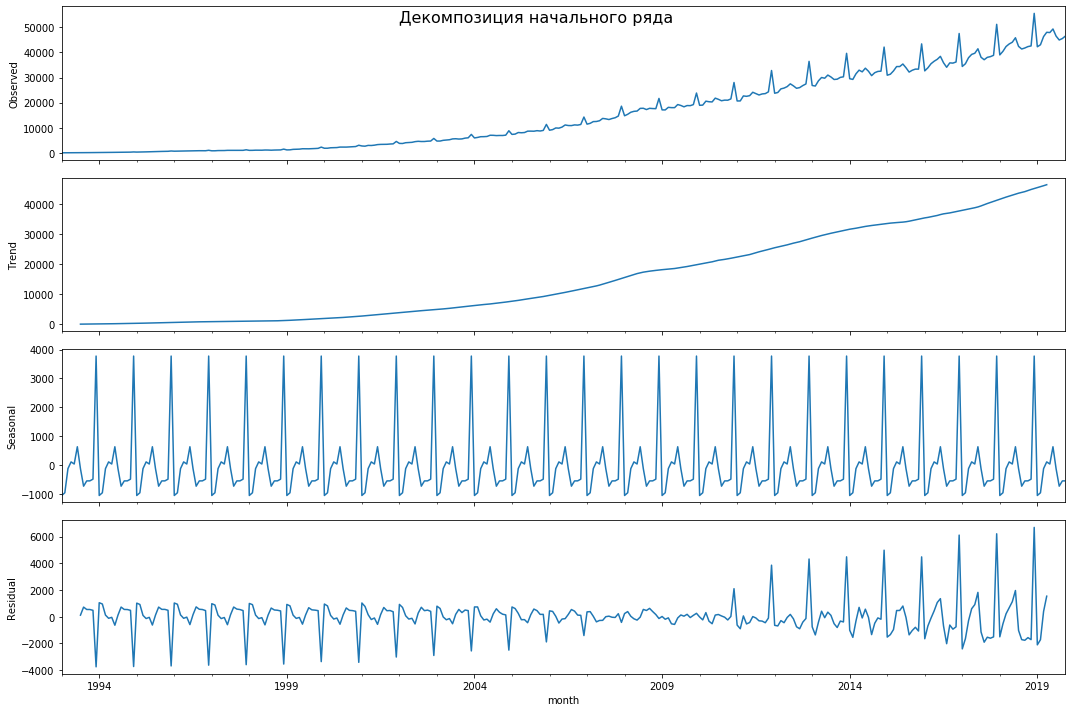

In [3]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage)[1])
plt.suptitle('Декомпозиция начального ряда', fontsize=16)
plt.show()

Критерий Дики-Фуллера > 0.05, что НЕ позволяет с уверенностью отвергнуть гипотезу о нестационарности ряда.

Визуальный анализ декомпозиции позволяет сделать следующие выводы:
- Есть тренд, но он не линейный, возможно преобразование Бокса-Кокса будет полезным и сделает его близким к линейному
- Есть выраженная сезонность с циклом 12 месяцев, необходимо будет сделать сезонное дифиренцирование со значением 12
- Остатки не похожи на "белый шум"


Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.288315


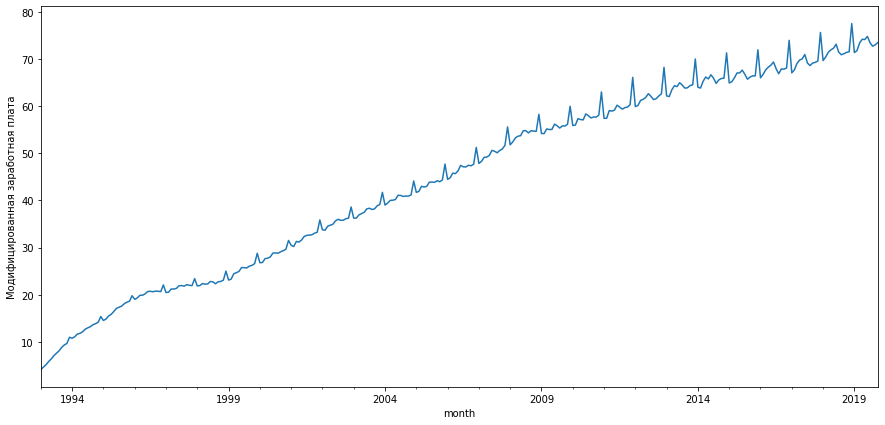

In [4]:
WAG['wage_box'], lmbda = stats.boxcox(WAG.wage)

plt.figure(figsize(15,7))
WAG.wage_box.plot()
plt.ylabel('Модифицированная заработная плата')
#plt.ylim((0, 80))
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
#print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box)[1])

Взглянем на критерий Дики-Фуллера, тренд и остатки после преобразования Бокса-Кокса

Критерий Дики-Фуллера: p=0.560462


<Figure size 1080x720 with 0 Axes>

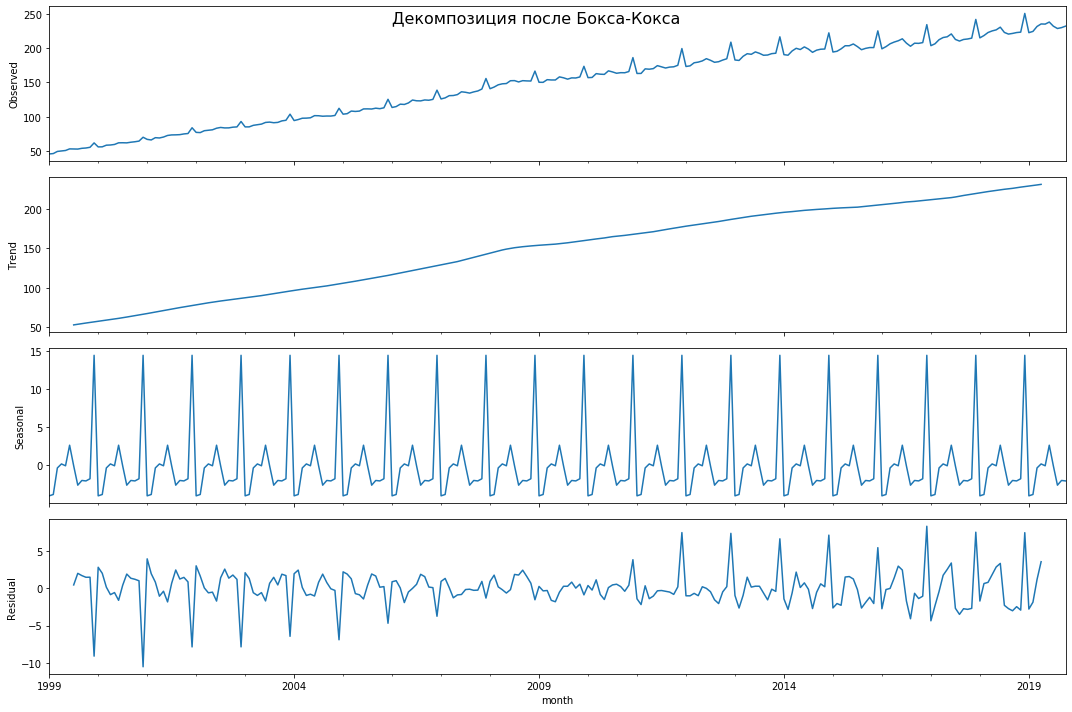

In [6]:
plt.figure(figsize(15,10))

sm.tsa.seasonal_decompose(WAG.wage_box).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box)[1])
plt.suptitle('Декомпозиция после Бокса-Кокса', fontsize=16)
plt.show()

По-прежнему Критерий Дики-Фуллера > 0.05, но незначительно уменьшился, что НЕ позволяет с уверенностью отвергнуть гипотезу о нестационарности ряда.

Визуальный анализ декомпозиции позволяет сделать следующие выводы:
- Тренд остался, но выглядит близко к линейному, дисперсия остатков значительно снизилась, преобразование сделало свое темное дело
- Осталась выраженная сезонность с циклом 12 месяцев, необходимо будет сделать сезонное дифиренцирование со значением 12
- Остатки похожи на "белый шум", но можно их сделать красивее


### 3. Диффиринцирование

Для начала попробуем сезонное дифференцирование; сделаем на продифференцированном ряде декомпозицию и проверим стационарность:

Предположим Сезонность = 12 месяцев.

Посмотрим на Декомпозицию после дифиринцирования на 12.

Критерий Дики-Фуллера: p=0.102881


<Figure size 1080x720 with 0 Axes>

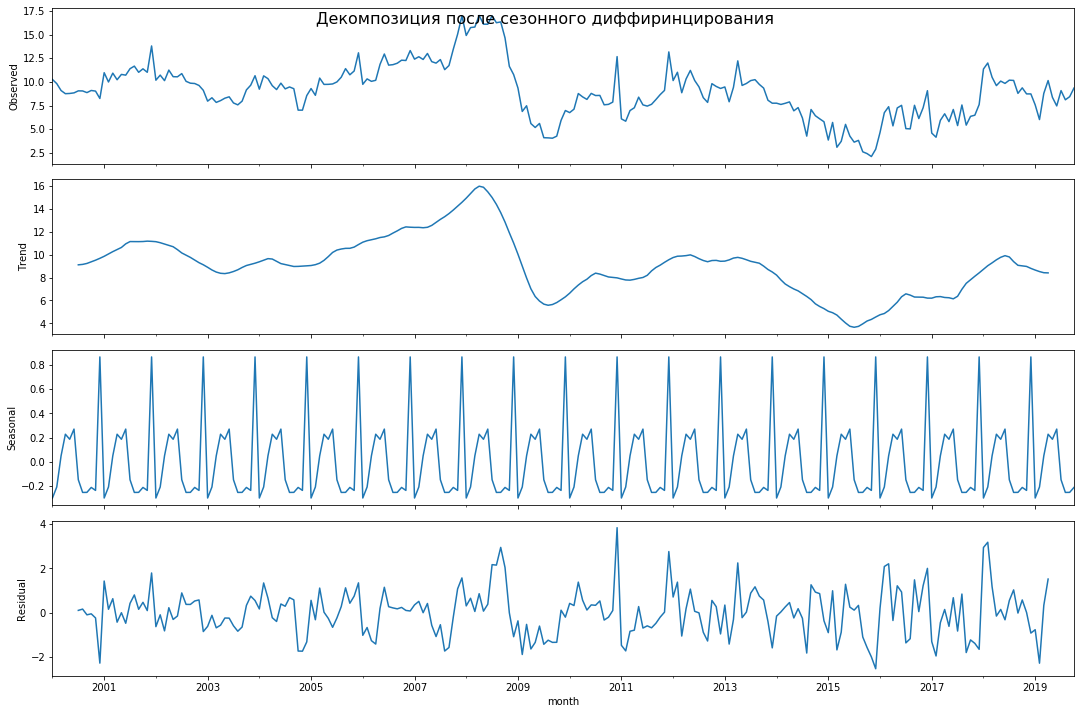

In [7]:
WAG['wage_box_diff'] = WAG.wage_box - WAG.wage_box.shift(12)

plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff.dropna()).plot()
plt.suptitle('Декомпозиция после сезонного диффиринцирования', fontsize=16)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff.dropna())[1])

In [8]:
print('Трендовая компонента:')
sm.tsa.seasonal_decompose(WAG.wage_box_diff.dropna()).trend.mean(), sm.tsa.seasonal_decompose(WAG.wage_box_diff.dropna()).trend.std()

Трендовая компонента:


(9.057180948554727, 2.50047787638358)

Критерий Дики-Фуллера < 0.05, что позволяет отвергнуть гипотезу о нестационарности ряда. То есть можно уже строить ARIMA модель, но попробуем подобрать оптимальный параметр d и уменьшить количество переборов.

Визуальный анализ декомпозиции позволяет сделать следующие выводы:
- Тренд остался, кроме того компонента смещенна относительно 0, возможно диффиринцирвание с параметром d=1 исправит проблему
- Сезонность исключена, компонента похожа на "белый шум"
- Остатки очень похожи на "белый шум"


Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

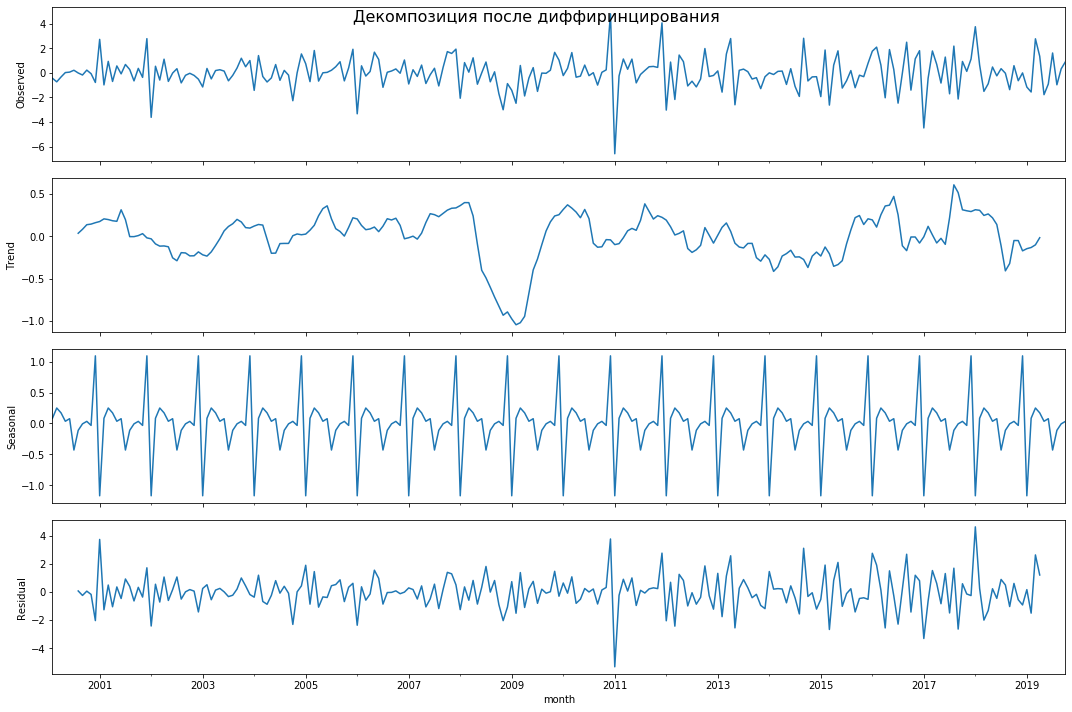

In [9]:
WAG['wage_box_diff2'] = WAG.wage_box_diff - WAG.wage_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff2.dropna()).plot()
plt.suptitle('Декомпозиция после диффиринцирования', fontsize=16)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff2.dropna())[1])

Критерий Дики-Фуллера < 0.05, что позволяет отвергнуть гипотезу о нестационарности ряда. Теперь можно строить ARIMA модель.

+ Сезонность = 12 месяцев
+ d = 1 или может 2?
+ D = 1


Визуальный анализ декомпозиции позволяет сделать следующие выводы:
- Тренд исключен
- Сезонность исключена
- Остатки еще больше похожи на "белый шум"


#### А вдруг d=2? Проверим!

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

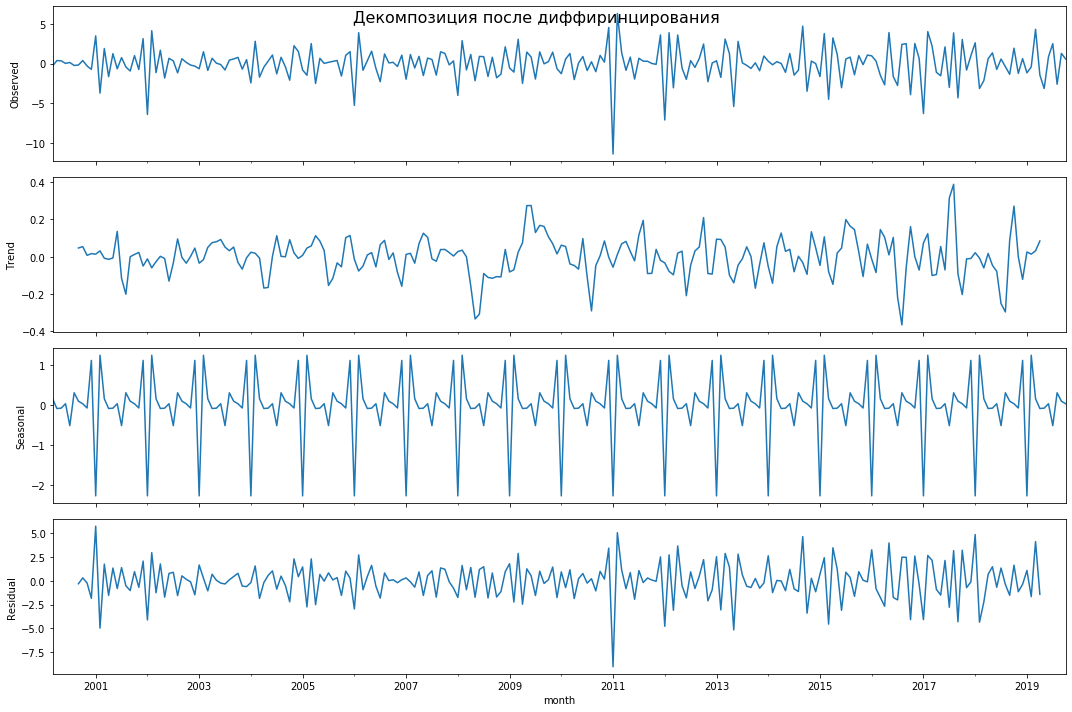

In [10]:
WAG['wage_box_diff3'] = WAG.wage_box_diff2 - WAG.wage_box_diff2.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(WAG.wage_box_diff3.dropna()).plot()
plt.suptitle('Декомпозиция после диффиринцирования', fontsize=16)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(WAG.wage_box_diff3.dropna())[1])

Хм, в части Трендовой компоненты всё стало красиво, но компонента сезонности и остатки кажется "испортились" :(

Проверим на графиках ACF и PCF!

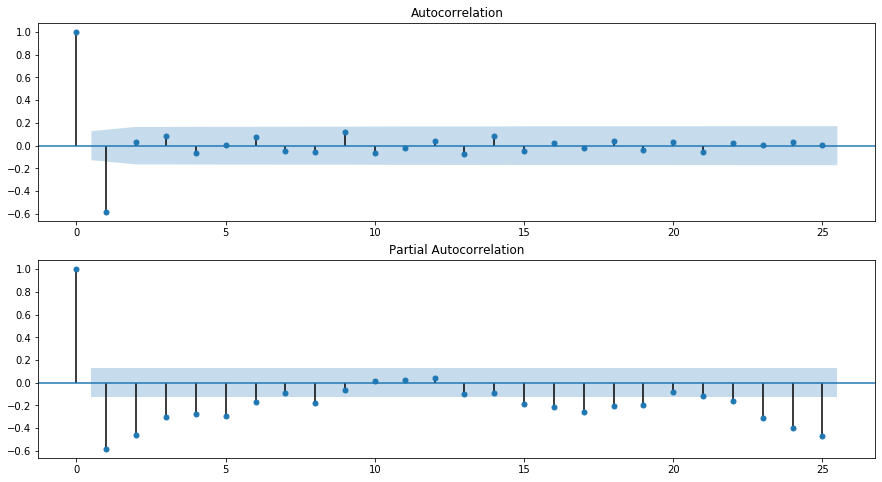

In [11]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.wage_box_diff3.dropna().values.squeeze(), lags=25, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.wage_box_diff3.dropna().values.squeeze(), lags=25, ax=ax)
plt.show()

Так не пойдет, второе диффиринцирование точно лишнее!

Удалим его из данных.

In [12]:
#WAG.drop('wage_box_diff3', axis=1, inplace=True)

### Выбор начальных приближений для p, q, P, Q 

Посмотрим на ACF и PACF полученного ряда:

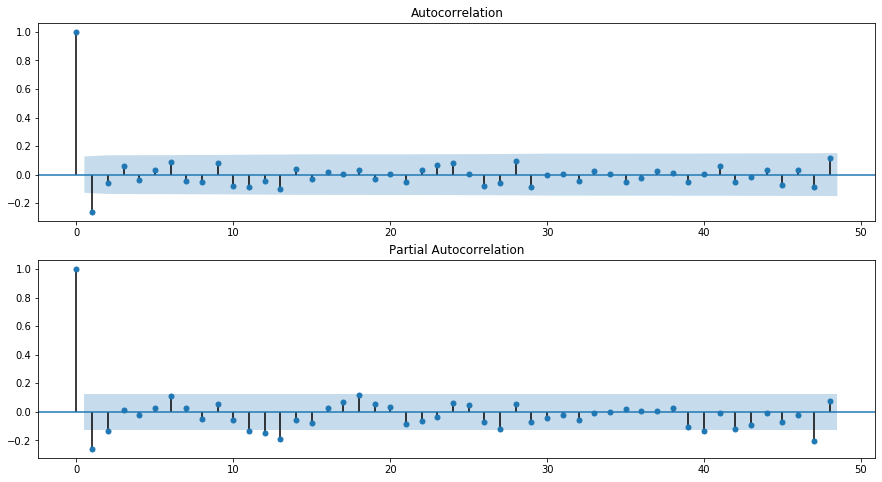

In [12]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(WAG.wage_box_diff2.dropna().values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(WAG.wage_box_diff2.dropna().values.squeeze(), lags=48, ax=ax)
plt.show()

Начальные приближения: Q=1, q=1, P=1, p=6

In [5]:
ps = range(0, 12)
d = 2
qs = range(0, 2)
Ps = range(0, 2)
D = 1
Qs = range(0, 2)

In [6]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)


96

In [7]:
%%time
results = []
models = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(WAG.wage_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12),
                                        trend=None).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    models.append(model)
    
warnings.filterwarnings('default')

Wall time: 1min 40s


In [8]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head(10))

       parameters         aic
94  (11, 1, 1, 0)  143.400696
55   (6, 1, 1, 1)  144.225880
63   (7, 1, 1, 1)  145.649881
54   (6, 1, 1, 0)  145.654302
95  (11, 1, 1, 1)  146.191923
93  (11, 1, 0, 1)  146.219401
71   (8, 1, 1, 1)  146.505488
62   (7, 1, 1, 0)  146.709156
70   (8, 1, 1, 0)  147.620776
79   (9, 1, 1, 1)  147.666856


Лучшая модель:

In [9]:
model_n = 94
print(models[model_n].summary())

                                  Statespace Model Results                                 
Dep. Variable:                            wage_box   No. Observations:                  322
Model:             SARIMAX(11, 2, 1)x(1, 1, 0, 12)   Log Likelihood                 -57.700
Date:                             Tue, 28 Jan 2020   AIC                            143.401
Time:                                     22:07:19   BIC                            195.622
Sample:                                 01-01-1993   HQIC                           164.281
                                      - 10-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2701      0.046     -5.809      0.000      -0.361      -0.179
ar.L2         -0.0584      

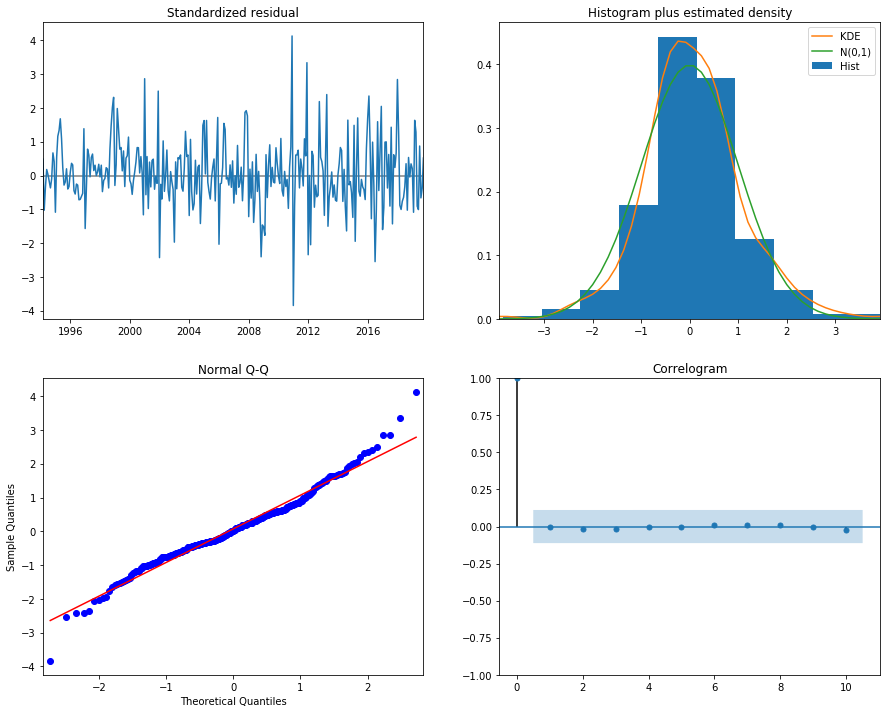

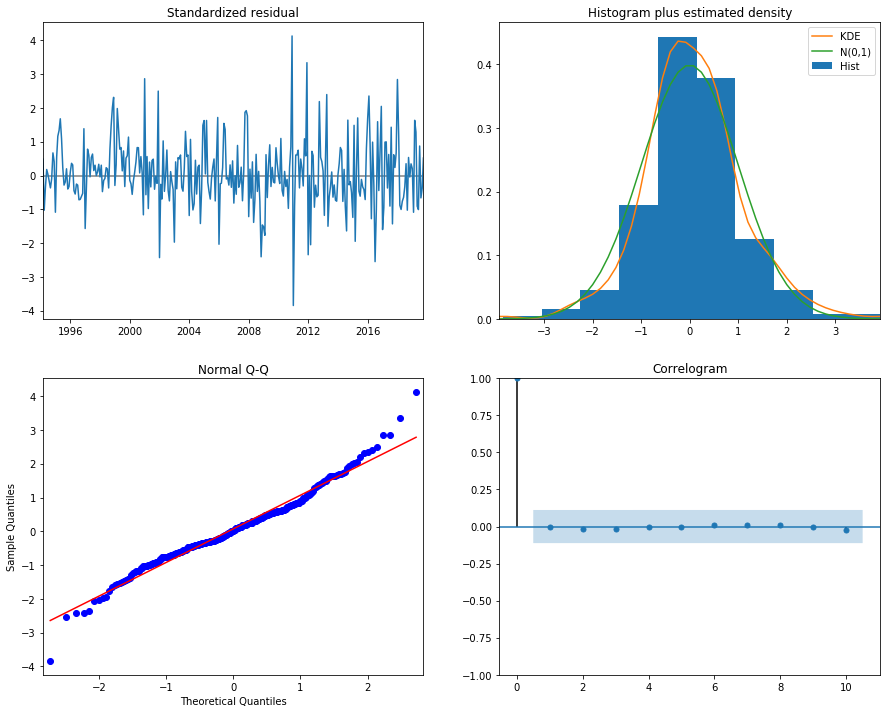

In [10]:
models[model_n].plot_diagnostics(figsize=(15,12))

Её остатки:

Критерий Стьюдента: p=0.145122
Критерий Дики-Фуллера: p=0.000000


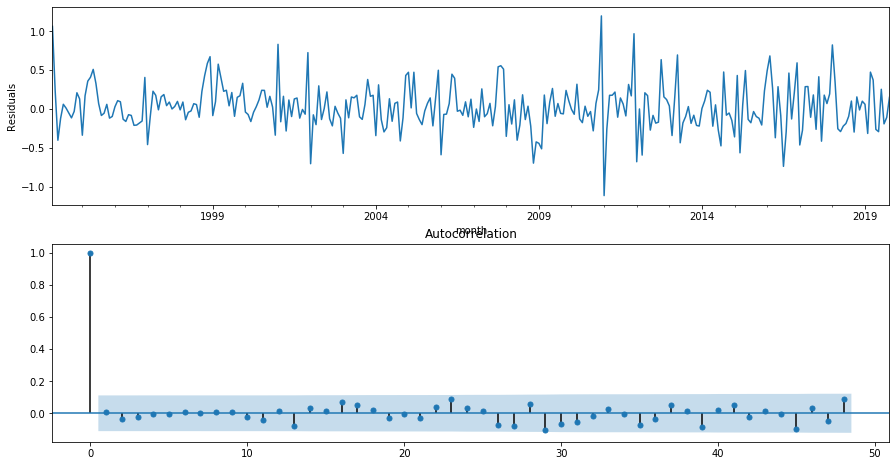

In [11]:
plt.figure(figsize(15,8))
plt.subplot(211)
models[model_n].resid[13:].plot()
plt.ylabel('Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(models[model_n].resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(models[model_n].resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(models[model_n].resid[13:])[1])

<BarContainer object of 29 artists>

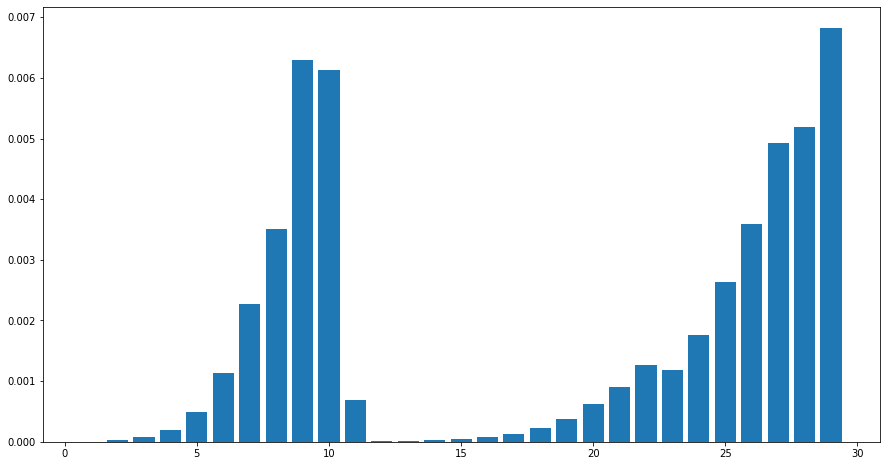

In [12]:
plt.bar(list(range(1,30)), sm.stats.acorr_ljungbox(models[model_n].resid, lags=list(range(1,30)))[1])

<BarContainer object of 29 artists>

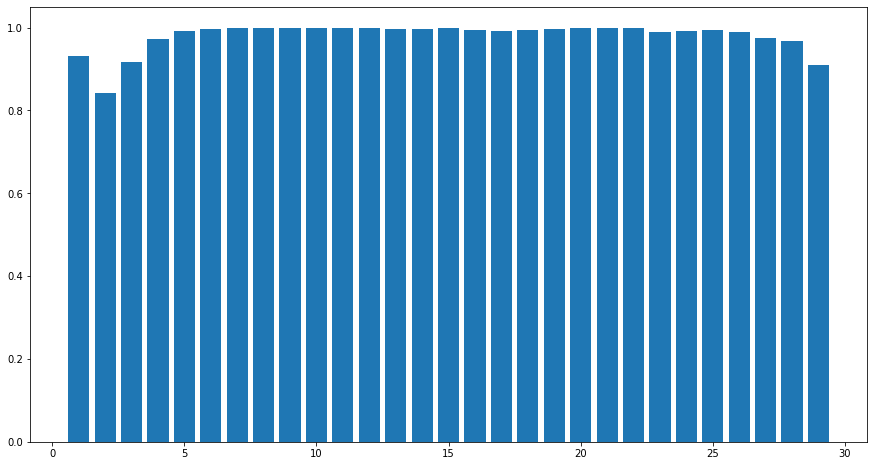

In [13]:
plt.bar(list(range(1,30)), sm.stats.acorr_ljungbox(models[model_n].resid[13:], lags=list(range(1,30)))[1])

In [22]:
q_test = sm.tsa.stattools.acf(models[model_n].resid[13:], qstat=True, nlags=24)
print(pd.DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}).mean())

Q-stat     3.482457
p-value    0.983232
dtype: float64


In [82]:
models[model_n].resid.mean(), models[model_n].resid.median(), models[model_n].resid.std()

(0.010787416957732686, -0.029082459554880202, 0.40526174477841803)

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

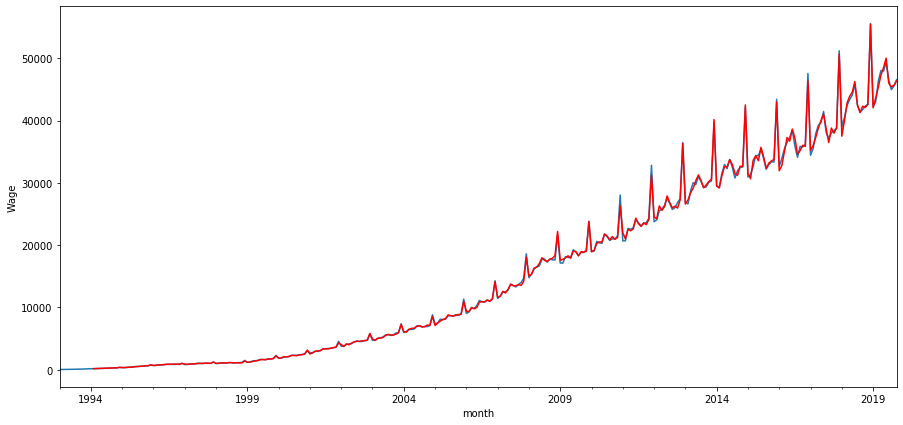

In [83]:
WAG['model'] = invboxcox(models[model_n].fittedvalues, lmbda)
plt.figure(figsize(15,7))
WAG.wage.plot()
WAG.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

### Прогноз

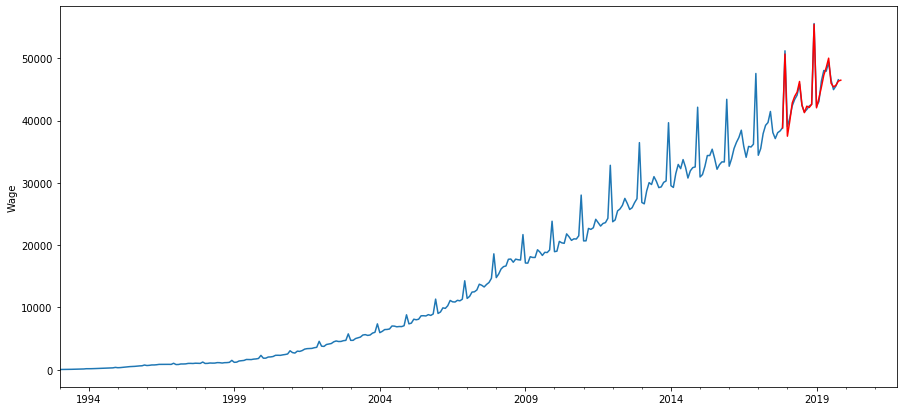

In [88]:
WAG2 = WAG[['wage']]
date_list = [datetime.datetime.strptime("2019-11-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns=WAG2.columns)
WAG2 = pd.concat([WAG2, future])
WAG2['forecast'] = invboxcox(models[model_n].predict(start=WAG[['wage']].shape[0]-24, end=WAG[['wage']].shape[0]), lmbda)

plt.figure(figsize(15,7))
WAG2.wage.plot()
WAG2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()

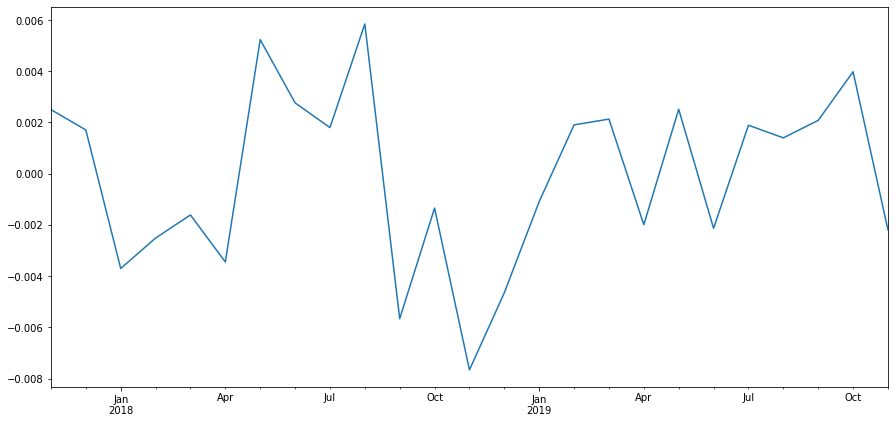

In [89]:
WAG2['forecast_2'] = invboxcox(models[51].predict(start=WAG[['wage']].shape[0]-24, end=WAG[['wage']].shape[0]), lmbda)

WAG2['diff'] = (WAG2.forecast - WAG2.forecast_2) / WAG2.forecast
WAG2['diff'].dropna().plot()

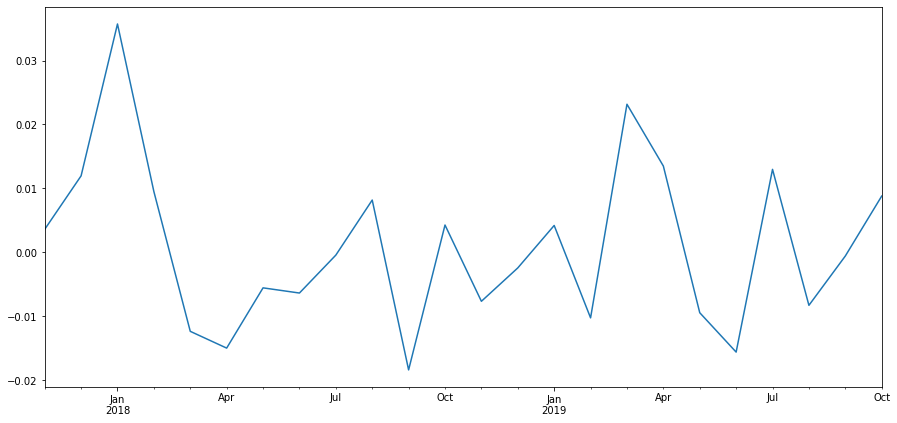

In [92]:
WAG2['diff_2'] = (WAG2.wage - WAG2.forecast_2) / WAG2.wage
WAG2['diff_2'].dropna().plot()